In [8]:
from sklearn.decomposition import DictionaryLearning
from sklearn.datasets import load_digits, make_sparse_coded_signal
import matplotlib.pyplot as plt 
import numpy as np
from utilities import *

# Dictionary learning

* Some images may be naturally sparse under different linear transforms
* We may not know a good transform, can we build one from a set of training images?

We need to solve

$$\min_{z, D} \sum_{i=1}^m \frac{1}{2}\|Dz_i - u_i\|_2^2 + \alpha \|z_i\|_1,$$

under suitable constraints on $D$.

In [9]:
n_train = 100
n_test = 50

digits = load_digits()
U_train = digits.data[:n_train]
U_test = digits.data[n_train:n_train+n_test]

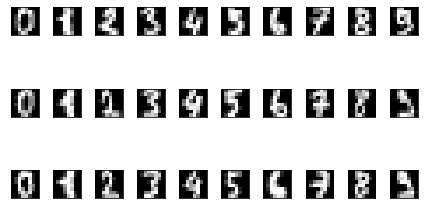

In [10]:
show_digits(U_train[:30],3,10)

In [11]:
# initialise dictionary learner
dict_learner = DictionaryLearning(n_components=15, transform_algorithm='lasso_lars', random_state=42)

# learn dictionary and fit
Z_train = dict_learner.fit_transform(U_train)

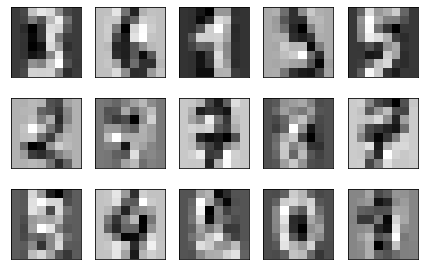

In [12]:
# plot dictionary elements
show_digits(dict_learner.components_,3,5)

In [13]:
# compute testing error
Z_test = dict_learner.transform(U_test)

# compute sparsity level
print('NNZ:', np.mean(Z_test == 0)/64/n_test)

# compute training error (MSE)
U_hat = Z_test @ dict_learner.components_
print('MSE:', np.mean(np.sum((U_hat - U_test) ** 2, axis=1) / np.sum(U_test ** 2, axis=1)))

NNZ: 6.916666666666666e-05
MSE: 0.05904831763475732


# Practical aspects

* In practice, we would learn a dictionary of image patches
* For an example, see [this code](https://scikit-learn.org/stable/auto_examples/decomposition/plot_image_denoising.html)

# Assignment: bias-variance

* look at the bias variance trade-off when varying the size of the dictionary

In [17]:
# generate training data
n_train = 100
n_test = 20
U,_,_ = make_sparse_coded_signal(n_samples = n_train + n_test, n_components = 15, n_features = 20, n_nonzero_coefs = 10)
U_train = np.copy(U[:,:n_train].T)
U_test = np.copy(U[:,n_train:n_test+n_train].T)

In [20]:
# helper functions for training and computing the emperical risk
def train(U, k, alpha):
    
    # initialise dictionary learner
    dict_learner = DictionaryLearning(n_components=k,transform_n_nonzero_coefs=10, transform_alpha = alpha, random_state=42, transform_algorithm = 'lasso_lars')

    # learn dictionary
    dict_learner.fit(U)
    
    #
    return dict_learner

def risk(D, U):
    Z = D.transform(U)
    Uh = Z @ D.components_
    
    return np.mean(np.sum((Uh - U) ** 2, axis=1)) / np.mean(np.sum((U) ** 2, axis=1))

MSE :  8.162861386731927e-05


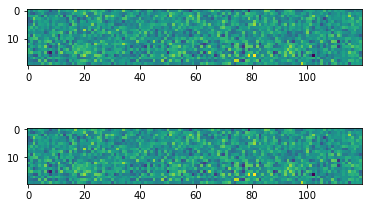

In [44]:
D = train(U, 200, 0.01)
Z = D.transform(U)
Uh = Z @ D.components_

print('MSE : ', np.mean(np.sum((Uh - U) ** 2, axis=1)) / np.mean(np.sum((U) ** 2, axis=1)))
fig, ax = plt.subplots(2,1)
ax[0].imshow(U)
ax[1].imshow(Uh)
plt.show()

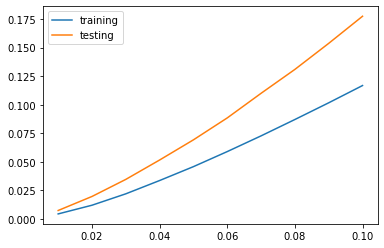

In [48]:
nc = 10
K = 50
alphas = np.linspace(0.01, .1, nc)
training_risk = np.zeros(nc)
testing_risk = np.zeros(nc)

for k in range(nc):
    D = train(U_train,K,alpha=alphas[k])
    training_risk[k] = risk(D, U_train)
    testing_risk[k] = risk(D, U_test)

plt.plot(alphas,training_risk,label='training')
plt.plot(alphas,testing_risk,label='testing')
plt.legend()

In [27]:
nc = 10
K = np.linspace(10,200,nc,dtype=int)
training_risk = np.zeros(nc)
testing_risk = np.zeros(nc)

for k in range(nc):
    D = train(U_train,K[k],alpha=2)
    training_risk[k] = risk(D, U_train)
    testing_risk[k] = risk(D, U_test)
    
plt.plot(K,training_risk,label='training')
plt.plot(K,testing_risk,label='testing')
plt.legend()